In [1]:
from datasets import load_dataset, Audio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Trainer, TrainingArguments
import torch

# Load dataset
data_files = {"train": "dataset.json", "test": "output.json"}
dataset = load_dataset("json", data_files=data_files)

# Prepare audio column
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Load pre-trained processor (using a smaller model)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Preprocess function
def preprocess_function(batch):
    audio = batch["audio"]["array"]
    batch["input_values"] = processor(audio, sampling_rate=16_000).input_values[0]
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

# Apply preprocessing
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio", "text"])

# Load the smaller model
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h",  # Use smaller model
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

# TrainingArguments (reduced batch size for low-end PC)
# TrainingArguments with reduced save steps to limit frequent saving
training_args = TrainingArguments(
    output_dir="./asr-subtitle-model",
    evaluation_strategy="epoch",
    save_strategy="no",  # Disable saving checkpoints
    learning_rate=3e-4,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    warmup_steps=100,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    fp16=True,
)


# Simple data collator function with padding
def data_collator(features):
    # Pad the input values (audio features) using the processor's feature_extractor
    input_values = [f["input_values"] for f in features]
    labels = [f["labels"] for f in features]
    
    # Pad both input values and labels correctly
    input_values = processor.feature_extractor.pad({"input_values": input_values}, padding=True, return_tensors="pt")
    labels = processor.tokenizer.pad({"input_ids": labels}, padding=True, return_tensors="pt")
    
    return {"input_values": input_values["input_values"], "labels": labels["input_ids"]}

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=processor.feature_extractor,
)

# Train the model
trainer.train()


c:\Users\anshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\anshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 22.512197494506836, 'eval_runtime': 12.2282, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.164, 'epoch': 0.8}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 22.333463668823242, 'eval_runtime': 11.9506, 'eval_samples_per_second': 0.92, 'eval_steps_per_second': 0.167, 'epoch': 1.6}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 21.970046997070312, 'eval_runtime': 11.7796, 'eval_samples_per_second': 0.934, 'eval_steps_per_second': 0.17, 'epoch': 2.4}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 20.678682327270508, 'eval_runtime': 8.9318, 'eval_samples_per_second': 1.232, 'eval_steps_per_second': 0.224, 'epoch': 4.0}
{'train_runtime': 183.7235, 'train_samples_per_second': 0.245, 'train_steps_per_second': 0.027, 'train_loss': 20.86092529296875, 'epoch': 4.0}


TrainOutput(global_step=5, training_loss=20.86092529296875, metrics={'train_runtime': 183.7235, 'train_samples_per_second': 0.245, 'train_steps_per_second': 0.027, 'total_flos': 2524220087163840.0, 'train_loss': 20.86092529296875, 'epoch': 4.0})

In [3]:
from moviepy.editor import VideoFileClip

def extract_audio(video_path, output_audio_path):
    try:
        # Load the video file
        video = VideoFileClip(video_path)
        
        # Extract the audio
        audio = video.audio
        
        # Save the audio file
        audio.write_audiofile(output_audio_path)
        print(f"Audio successfully extracted and saved to: {output_audio_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Close video and audio objects
        if 'video' in locals():
            video.close()
        if 'audio' in locals() and audio is not None:
            audio.close()

# Example usage
video_file = "video2.mp4"
audio_file = "audio11.wav"
extract_audio(video_file, audio_file)


MoviePy - Writing audio in audio11.wav


MoviePy - Done.
Audio successfully extracted and saved to: audio11.wav


In [2]:
model.save_pretrained("./subtitle-generator")
processor.save_pretrained("./subtitle-generator")

[]

In [6]:
from transformers import pipeline

# Load fine-tuned model and processor
asr_pipeline = pipeline("automatic-speech-recognition", model="./subtitle-generator", tokenizer=processor)

# Input audio file
#  = "E:\main_project\model_generation\dataset\wavs\LJ001-0034.wav"
audio_path = "audio.wav"
result = asr_pipeline(audio_path)
transcript = result["text"]

print("Transcript:", transcript)


Transcript: HUMANS NEED LANGUAGE TO COMMUNICATE SO IT MAKES SENSE THAT A I DOES TOO A LARGE LANGUAGE MODEL OR ELLEM IS A TYPE OF A I ALGARITHM BASED ON DEEP LEARNING AND HUGE MOUNTS OF DATA THAT CAN UNDERSTAND GENERATE AND PREDICT NEW CONTENT LANGUAGE MODELS AREN'T NEW THE FIRST A I LINGUAGE MODEL CAN BE TRACED BACK TO NINETEEN SIXTY SIX BUT LARGE LINGUAGE MODELS USE A SIGNIFICANTLY LARGERPOOL OF DATA FOR TRAINING WHICH MEANS A SIGNIFICANT INCREASE IN TH CAPABILITIES OF THE A I MODEL ONE OF THE MOST COMMON APPLICATIONS OF L LEMS RIGHT NOW IS GENERATING CONTENT USING A I CHAPBOTS MORE AND MORE POPPING UP IN THE MARKET AS COMPETITORS LOOK TO DIFERENTIATE THEMSELVES CHECK OUT THE LING ABOVE OR THE DESCRIPTION BELOW TO SEE HOW TWO OF THE FRONT RUNNERS CHAT  B T AND BARRED COMPARE AND REMEMBERED A SUBSCRIBE TO I ONTAC FOR MORVIDIOS ON ALL THINGS BUSINESS TEC SO JUST HOW LARGE ARE LARGE LANGUAGE MODELS WELL THERE'S NO UNIVERSEALY ACCEPTED FIGURE FOR HOW LARGE AN L LE TRAINING DATA SAT IS BUT

In [5]:
from jiwer import wer, cer

# Ground truth and predicted transcripts
ground_truth = "This is the actual transcription."
predicted = transcript

# Calculate metrics
word_error_rate = wer(ground_truth, predicted)
char_error_rate = cer(ground_truth, predicted)

print(f"Word Error Rate (WER): {word_error_rate:.2f}")
print(f"Character Error Rate (CER): {char_error_rate:.2f}")

Word Error Rate (WER): 42.20
Character Error Rate (CER): 31.52


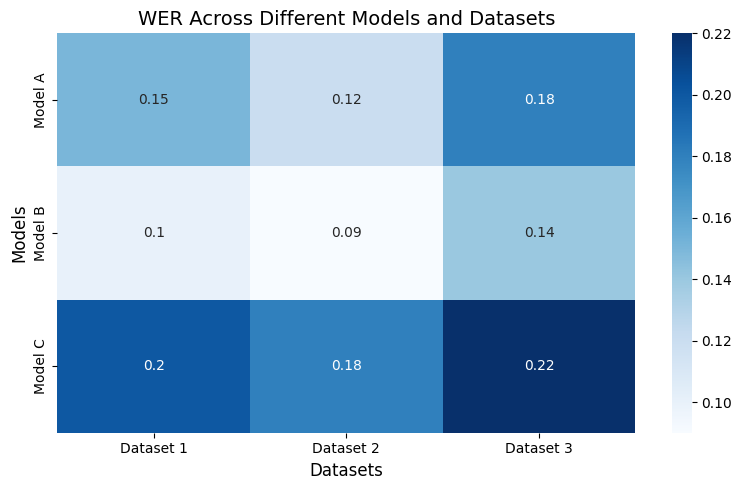

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Example data (rows: models, columns: different datasets)
wer_matrix = np.array([
    [0.15, 0.12, 0.18],  # Model A
    [0.10, 0.09, 0.14],  # Model B
    [0.20, 0.18, 0.22]   # Model C
])

# Create the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(wer_matrix, annot=True, cmap="Blues", xticklabels=['Dataset 1', 'Dataset 2', 'Dataset 3'], yticklabels=['Model A', 'Model B', 'Model C'])

# Adding titles and labels
plt.title('WER Across Different Models and Datasets', fontsize=14)
plt.xlabel('Datasets', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Display the heatmap
plt.tight_layout()
plt.show()
